# A/B Testing Marketing Promotions

Promosi apa yang paling efekif ?

**Scenario** :

<p>Sebuah restoran masakan cepat saji merencanakan untuk menambahkan menu baru. Namun, mereka belum memutuskan antara 3 kemungkinan marketing campaign untuk promosi untuk produk baru. Dalam rangkah untuk menentukan promosi yang memiliki dampak terbesar pada penjualan, menu baru diperkenalkan pada lokasi yang berbeda dengan memilih market secara acak. Promosi yang berbeda digunakan pada setiap lokasi dan penjualan mingguan menu baru dicatat dari minggu pertama hingga minggu ke empat</p>

# Import Library

In [2]:
#=========== Pandas =============
import pandas as pd
pd.set_option("display.max_columns",None)

#===== Vector and Matrix ======
import numpy as np

#===== Stats =======
import scipy
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import kruskal
from scipy.stats import mannwhitneyu
#========= Visualisasi ==========
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

#======= Function ========
def missing_check(df):
    missing=df.isnull().sum()
    per_mis = 100*(missing/len(df))
    data_type = df.dtypes
    number_unique = df.nunique()
    return pd.DataFrame({"Missing":missing,
                        "Percent_Missing":per_mis,
                        "Data_Types":data_type,
                        "Number_of_Unique":number_unique})


#===== warning filters =====
import warnings
warnings.filterwarnings("ignore")

# Load Dataset

In [3]:
df = pd.read_csv("WA_Marketing-Campaign.csv")

# Data Investigation

In [4]:
df.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


In [5]:
missing_check(df)

,Missing,Percent_Missing,Data_Types,Number_of_Unique
MarketID,0,0.0,int64,10
MarketSize,0,0.0,object,3
LocationID,0,0.0,int64,137
AgeOfStore,0,0.0,int64,25
Promotion,0,0.0,int64,3
week,0,0.0,int64,4
SalesInThousands,0,0.0,float64,517


# Eksplonatory Data Analysis

## Check Sample Size for Each Promotion

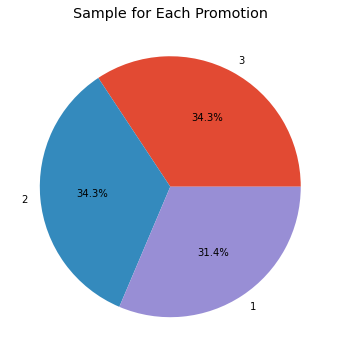

In [6]:
plt.figure(figsize=(8,6))
plt.pie(df["Promotion"].value_counts(),
       autopct="%1.1f%%",
       labels=df["Promotion"].value_counts().index)
plt.title("Sample for Each Promotion")
plt.show()

In [7]:
#calculate mean,standard deviation from SalesInThousands
mean_ = df["SalesInThousands"].mean()
std_ = df["SalesInThousands"].std()

print(f"Rata-Rata Sales {mean_}")
print(f"Standard Deviasi sales {std_}")

Rata-Rata Sales 53.46620437956198
Standard Deviasi sales 16.755215821664237


## Sales for Each Promotion and Market Size

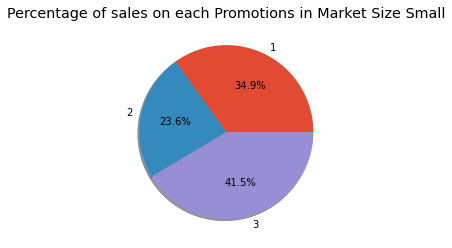

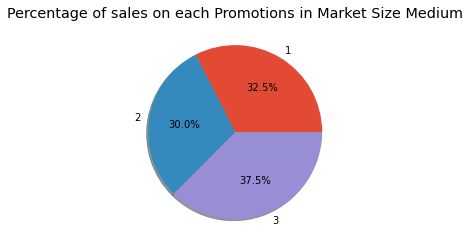

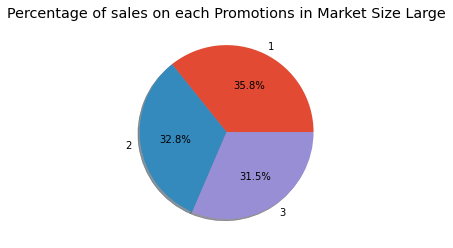

In [8]:
for x in ['Small', 'Medium','Large']:
    plt.figure()
    ax = df[df["MarketSize"]==x].groupby("Promotion")["SalesInThousands"].sum().plot.pie(
             autopct="%1.1f%%",
             shadow=True)

    ax.set_title(f"Percentage of sales on each Promotions in Market Size {x}")
    ax.set_ylabel("")

    plt.show()

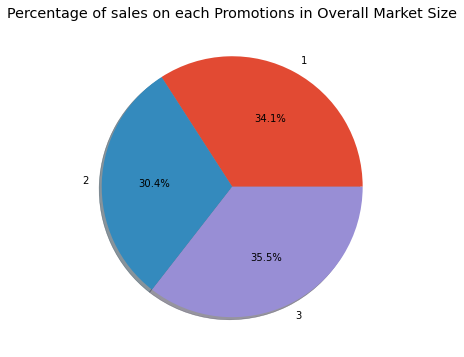

In [9]:
#create pie chart to see percentage sales by promotion
plt.figure(figsize=(8,6))
ax = df.groupby("Promotion")["SalesInThousands"].sum().plot.pie(
             autopct="%1.1f%%",
             shadow=True)

ax.set_title("Percentage of sales on each Promotions in Overall Market Size")
ax.set_ylabel("")

plt.show()

Promotion 1 has a good sales contribution in the large market segment, while promotion 3 has a good sales contribution in the small and medium market segment. <br> 

In aggregate, Promotion 3 contributed 35.5% to sales and was the highest compared to promotions 1 and 2, but if we look at the difference in sales for each promotion, it is not much different, it is necessary to test to find out the difference. in sales is very significant.

## Promotion for each market size

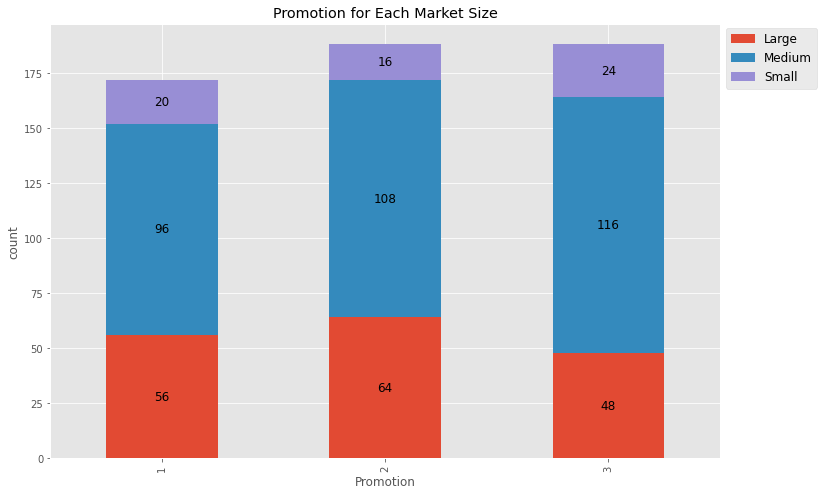

In [10]:
ax = df.groupby(["Promotion","MarketSize"])['MarketID'].count().unstack(level=1)\
                                                          .plot(kind="bar",
                                                                stacked=True,
                                                               figsize=(12,8))

cols = df.groupby(["Promotion","MarketSize"])['MarketID'].count().unstack(level=1).columns
# iterate through each container and add custom annotations
for i, c in enumerate(ax.containers):
    
    # customize the label to account for cases when there might not be a bar section - with assignment expression (h := ...)
    labels = [f'{cols[i]}: {h:0.0f}' if (h := v.get_height()) > 0 else '' for v in c ]
    # without assignment expression v.get_height() must be called twice
    # labels = [f'{cols[i]}: {v.get_height():0.0f}' if v.get_height() > 0 else '' for v in c ]
    
    # set the bar label
    ax.bar_label(c, label_type='center', fontsize=12)

ax.set_title("Promotion for Each Market Size")
ax.set_ylabel("count",fontsize=12)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.92),fontsize=12)
plt.show()

market size menengah memiliki jumlah yang lebih banyak disemua kategori promosi, sedangkan market size small memiliki jumlah terkecil diantara semua kategori promosi. Berdasarkan plot dan data, market size yang berbeda memiliki kecendrungan yang sama pada tiap promosi.

## Age Store Distribution

Text(0, 0.5, 'Count')

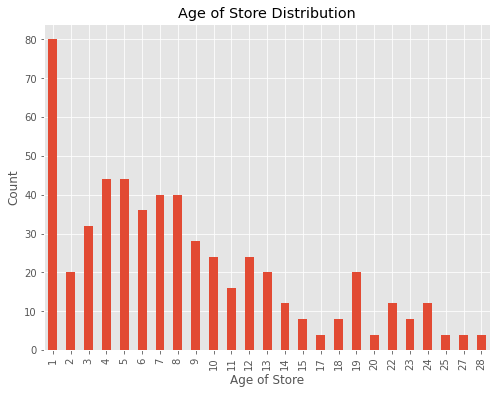

In [11]:
ax = df.groupby("AgeOfStore")["MarketID"].count().plot(kind='bar',
                                                      figsize=(8,6))
ax.set_title("Age of Store Distribution")
ax.set_xlabel("Age of Store")
plt.ylabel("Count")

Most of stores have 1 year old

## Distribution Age every Promotion

In [12]:
df.groupby("Promotion")["AgeOfStore"].describe()

,count,mean,std,min,25%,50%,75%,max
Promotion,,,,,,,,
1,172.0,8.279070,6.636160,1.0,3.0,6.0,12.0,27.0
2,188.0,7.978723,6.597648,1.0,3.0,7.0,10.0,28.0
3,188.0,9.234043,6.651646,1.0,5.0,8.0,12.0,24.0


The average age of the store from 3 different promotions is in the range of 8-9 years and most of the age of the store is 10-12 years (quantile 3)

## Normality Test

Hypothesis : <br>
H0 = Normal Distribution <br>
H1 = Not Normal Distribution

In [13]:
#Sales in promotion 1
promotion_1 = df[df["Promotion"]==1]["SalesInThousands"]
promotion_2 = df[df["Promotion"]==2]["SalesInThousands"]
promotion_3 = df[df["Promotion"]==3]["SalesInThousands"]

# Promotion 1 test 
t1,p1=shapiro(promotion_1)
print("---Promotion 1 Normality Test---")
print(f" P-value is {p1}")

# Promotion 2 test 
t2,p2=shapiro(promotion_2)
print("---Promotion 2 Normality Test---")
print(f" P-value is {p2}")

# Promotion 3 test 
t3,p3=shapiro(promotion_3)
print("---Promotion 3 Normality Test---")
print(f" P-value is {p3}")

---Promotion 1 Normality Test---
 P-value is 1.9773297665892642e-08
---Promotion 2 Normality Test---
 P-value is 5.456262108793908e-09
---Promotion 3 Normality Test---
 P-value is 1.499518376135711e-08


Based shapiro test we can see that sales for every promotions have p-value **close to 0** so this is indicate sales not normal distribution, so for statistical test we use is non-parametric test

## Variance Equal Check

Because our sales data is not normal distribution, we can use statistical test levene to see if our variance is equal or not. <br>

Levene Hypothesis <br>
Ho = there is not different <br>
H1 = at least 1 population not have equal variance

In [14]:
stat, p = levene(promotion_1, promotion_2, promotion_3)

if p<0.05:
    print("Reject Null Hypothesis")
else:
    print("Fail to reject Null Hypothesis")

Fail to reject Null Hypothesis


based on levene test, we know that every varince is equal

In [15]:
print(f"Variance sales for promotion 1 is {promotion_1.std()}")
print(f"Variance sales for promotion 2 is {promotion_2.std()}")
print(f"Variance sales for promotion 3 is {promotion_3.std()}")

Variance sales for promotion 1 is 16.553781697578724
Variance sales for promotion 2 is 15.108954782812802
Variance sales for promotion 3 is 16.766230774027896


if we see the variance sales for every promotion, we can see that the variance for every promotion is not equal

# A/B Test : Kruskal Test Non Parametric and Post-Hoc Mannwhitneyu

In [16]:
df.groupby("Promotion")["SalesInThousands"].describe()

,count,mean,std,min,25%,50%,75%,max
Promotion,,,,,,,,
1,172.0,58.099012,16.553782,30.81,46.3525,55.385,63.6175,99.65
2,188.0,47.329415,15.108955,17.34,38.1700,45.385,51.7450,88.64
3,188.0,55.364468,16.766231,22.18,44.1975,51.165,61.7325,96.48


Berdasarkan dari permasalahan utama business yaitu menentukan strategi yang paling efisien dan berhasil, sehingga untuk mengetahui strategy yang efisien dan berhasil kita perlu melakukan pengujian A/B untuk mengetahui strategy paling efisien secara signifikan.

## Kruskal Test

Hypothesis Kruskal Test : <br>
Ho =  the population median sales of all promotion are equal <br>
H1 =  at least one of the population median sales of all promotion are not equal

In [17]:
stast_kruskal,p_value = kruskal(promotion_1,promotion_2,promotion_3)

if p_value <0.05:
    print("Reject Null Hypothesis")
else:
    print("Fail to reject Null Hypothesis")

Reject Null Hypothesis


based on kruskal test we can confidence that the median sales for every promotion is significant difference

## Post-Hoc Test : Mannwhitneyu

based on our EDA, we can see that the sample promotion is not equal so we can use mannwhitneyu for post-hoc test

In [18]:
post_hoc = pd.DataFrame()

#promotion test significant

promo = [(1,2),(1,3),(2,3)]

for n,p in promo:
      post_hoc = post_hoc.append(pd.DataFrame([list(mannwhitneyu(x = df[df['Promotion']==p]['SalesInThousands'],y = df[df['Promotion']==n]['SalesInThousands']))],
                     columns = ['stat','p-value']))
      
post_hoc


,stat,p-value
0,9378.5,5.845935e-12
0,14089.0,3.508410e-02
0,23251.0,1.197008e-07


# Conclusion

based on kruskal test we can confindence that median sales for every promotion is statistical siginificance and the post hoc test we can see the p-value for every test promotion close to 0, so we can confirm that sales in every promotion is significant difference, and based on our data the average sales for promotion 1 is higher, so the promotion 1 is effective